In [1]:
import pandas as pd
import os

df = pd.DataFrame()
"""
for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)])
    print(f"Added {json_file} to dataframe.")
"""
df = pd.read_json('dataset/jsonl/en-US.jsonl', lines=True)
df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

In [2]:
%run -i "preprocess_lang.ipynb"
%run -i "preprocess_nolang.ipynb"
%run -i "evaluation.ipynb"

In [3]:
from toolz.functoolz import pipe

params = [
    remove_punctuation,
    lowercase,
    tokenize
]

df = pipe(
    df,
    *params
)


In [4]:
import numpy as np

def tokens_to_mean_vector(embeddings, tokens):
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens):   # while there are tokens
        try:
            vec.append(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # return the mean of vec
    return np.mean(vec, axis=0)    


In [8]:
from gensim.models import Word2Vec

model = Word2Vec.load(f'D:\models\en.model')
print(f"Loaded en model.")

Loaded en model.


In [20]:
for lang in df['locale'].unique():
    print(f"Adding {lang} embeddings to dataframe.")
    # apply tokens_to_mean_vector to each utterance with locale == lang
    for i, row in df[df['locale'] == lang].iterrows():
        df.at[i, 'utt'] = tokens_to_mean_vector(model.wv, row['utt'])
    print(f"Added {lang} embeddings to dataframe. Deleting model.")


Adding en embeddings to dataframe.
Added en embeddings to dataframe. Deleting model.


In [26]:
input_cols = [f'utt_{i}' for i in range(300)]
for i in range(300):
    df[f'utt_{i}'] = df['utt'].apply(lambda x: x[i])

C:\Users\nrtc\AppData\Local\Temp\ipykernel_18928\3914574139.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'utt_{i}'] = df['utt'].apply(lambda x: x[i])
C:\Users\nrtc\AppData\Local\Temp\ipykernel_18928\3914574139.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'utt_{i}'] = df['utt'].apply(lambda x: x[i])
C:\Users\nrtc\AppData\Local\Temp\ipykernel_18928\3914574139.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [27]:
df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,utt_text,utt_0,...,utt_290,utt_291,utt_292,utt_293,utt_294,utt_295,utt_296,utt_297,utt_298,utt_299
0,0,en,test,alarm,alarm_set,"[0.02374037, -0.10971783, 0.1179467, 0.0553602...",wake me up at [time : five am] [date : this week],1,"(w, a, k, e, , m, e, , u, p, , a, t, , f, ...",0.023740,...,0.129545,-0.015426,-0.287220,0.072414,0.021808,0.018839,-0.011701,0.204422,-0.033505,-0.001701
1,1,en,train,alarm,alarm_set,"[0.02635483, -0.063925914, 0.12291399, 0.06185...",wake me up at [time : nine am] on [date : friday],1,"(w, a, k, e, , m, e, , u, p, , a, t, , n, ...",0.026355,...,0.097372,-0.013342,-0.299295,0.061895,0.008075,0.021580,0.008930,0.172068,-0.047982,-0.022944
2,2,en,train,alarm,alarm_set,"[0.0149873, -0.03628377, 0.022763085, 0.090717...",set an alarm for [time : two hours from now],1,"(s, e, t, , a, n, , a, l, a, r, m, , f, o, ...",0.014987,...,0.079397,0.070716,-0.050164,-0.034825,-0.045124,-0.023538,-0.031646,0.199483,-0.006318,-0.014939
3,3,en,test,audio,audio_volume_mute,"[-0.059513863, -0.079797, -0.011928498, 0.0888...",quiet,1,"(q, u, i, e, t)",-0.059514,...,0.080874,-0.001509,-0.056021,-0.000028,0.019974,-0.035629,0.007633,0.078737,-0.063585,0.063456
4,4,en,train,audio,audio_volume_mute,"[-0.017824091, -0.035481222, 0.052026093, 0.09...",olly quiet,1,"(o, l, l, y, , q, u, i, e, t)",-0.017824,...,0.020328,0.056281,-0.137947,-0.009079,0.014584,-0.010109,0.043367,0.111444,-0.053675,-0.028138


In [28]:
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

Best params for DecisionTreeClassifier: {'model__splitter': 'best', 'model__min_samples_split': 11, 'model__min_samples_leaf': 5, 'model__max_features': 184, 'model__max_depth': 3, 'model__criterion': 'gini'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.025184240500457065
Classification report
                          precision    recall  f1-score   support

             alarm_query     1.0000    0.0000    0.0000        34
            alarm_remove     1.0000    0.0000    0.0000        21
               alarm_set     1.0000    0.0000    0.0000        41
       audio_volume_down     1.0000    0.0000    0.0000        11
       audio_volume_mute     1.0000    0.0000    0.0000        32
      audio_volume_other     1.0000    0.0000    0.0000         6
         audio_volume_up     1.0000    0.0000    0.0000        13
          calendar_query     1.0000    0.0000    0.0000       126
         calendar_remove     1.0000    0.0000    0.0000        67
  

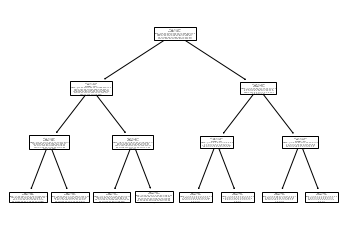

In [30]:
model1 = train_and_use_model(
    DecisionTreeClassifier(),
    {
        "model__criterion": ['gini', 'entropy'],
        'model__splitter': ['best', 'random'],
        "model__max_depth": range(1, 15),
        'model__max_features': range(1, len(input_cols)),
        "model__min_samples_split": range(2,15),
        "model__min_samples_leaf": range(1,7)
    },
    n_iter=1,
)